In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [2]:
df = pd.read_csv("Tweets.csv")
df[["airline_sentiment","text"]].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


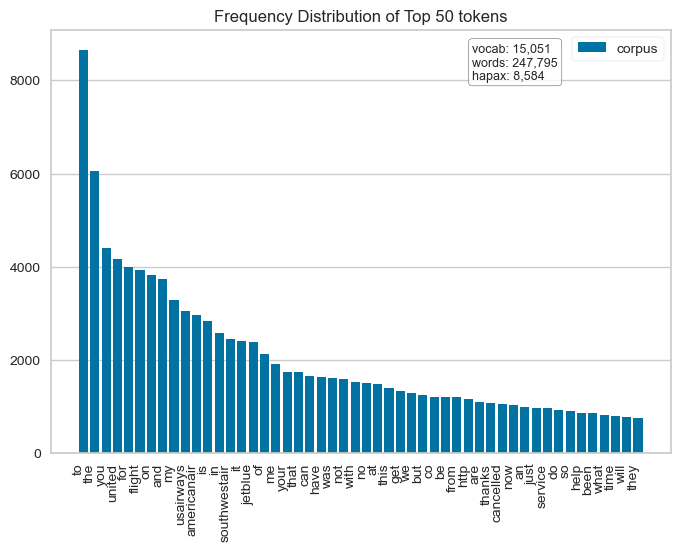

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
text = df["text"]
labels = df["airline_sentiment"]

print(text.shape, labels.shape)

(14640,) (14640,)


In [5]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

text.shape

(14640,)

In [6]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [69]:
with open("text.pkl", "rb") as f:
  text = pickle.load(f)
with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

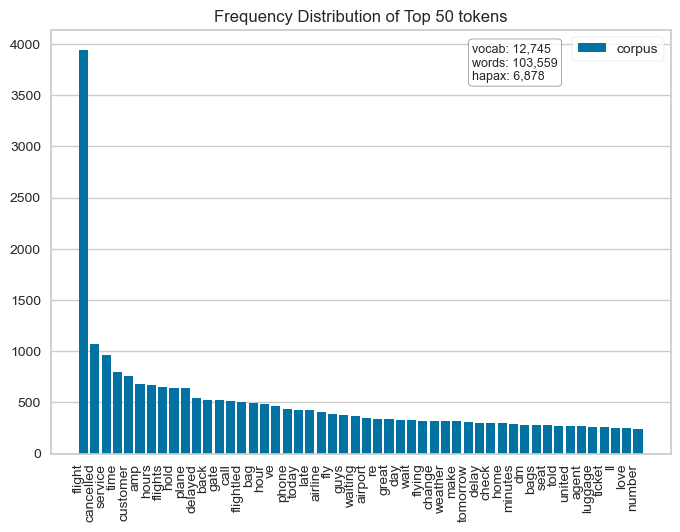

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [7]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [71]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == "positive")), np.mean((lengths < 64) & (labels == "positive")))
print(np.sum((lengths < 64) & (labels == "neutral")), np.mean((lengths < 64) & (labels == "neutral")))
print(np.sum((lengths < 64) & (labels == "negative")), np.mean((lengths < 64) & (labels == "negative")))

2363 0.16140710382513662
3099 0.21168032786885246
9178 0.6269125683060109


In [72]:
X_positive = X[(lengths < 64) & (labels == "positive")].tolist()
X_neutral = X[(lengths < 64) & (labels == "neutral")].tolist()
X_negative = X[(lengths < 64) & (labels == "negative")].tolist()
X = X_positive[:2000] + X_neutral[:2000] + X_negative[:2000]

y_positive = labels[(lengths < 64) & (labels == "positive")].tolist()
y_neutral = labels[(lengths < 64) & (labels == "neutral")].tolist()
y_negative = labels[(lengths < 64) & (labels == "negative")].tolist()
y = y_positive[:2000] + y_neutral[:2000] + y_negative[:2000]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [79]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [80]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2066, -0.0282, -0.1487,  ..., -0.6622,  0.9191, -0.2197],
         [-0.2415,  0.0171, -0.0644,  ..., -0.6244,  0.9475, -0.1599],
         [-0.1781,  0.0085, -0.0482,  ..., -0.5726,  0.8681, -0.1740],
         ...,
         [-0.1854, -0.0959, -0.0056,  ..., -0.7813,  0.9637, -0.2053],
         [-0.1866, -0.0897, -0.0079,  ..., -0.7701,  0.9756, -0.2047],
         [-0.1825, -0.0569, -0.0226,  ..., -0.7687,  0.9623, -0.2147]],

        [[-0.3026,  0.1684, -0.0352,  ..., -0.9145,  0.5193, -0.0264],
         [-0.4256,  0.1851,  0.1178,  ..., -0.4734,  0.5800,  0.2565],
         [-0.2717, -0.0220,  0.0848,  ..., -0.5980,  0.4316,  0.1030],
         ...,
         [-0.3217,  0.0754,  0.0690,  ..., -0.9616,  0.5710, -0.1714],
         [-0.3329,  0.0838,  0.0734,  ..., -0.9575,  0.5849, -0.1584],
         [-0.3284,  0.1011,  0.0585,  ..., -0.9653,  0.5685, -0.1693]],

        [[-0.2317, -0.1498, -0.0387,  ..., -0.7898,  

In [81]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [82]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-3.1295e-01,  1.5561e-01, -2.7687e-02,  ..., -4.8513e-01,
           7.5616e-01, -2.3316e-02],
         [-5.4890e-01,  5.1504e-02,  1.6730e-01,  ..., -3.4659e-01,
           1.8041e-01,  1.8791e-02],
         [-7.7897e-01,  3.8784e-01,  1.7131e-01,  ..., -3.6748e-01,
          -2.0138e-02, -2.8385e-01],
         ...,
         [-2.4383e-01, -8.9378e-02,  5.6035e-02,  ..., -5.5533e-01,
           1.0609e+00, -9.2632e-02],
         [-2.5183e-01, -9.6665e-02,  5.5533e-02,  ..., -5.3142e-01,
           1.0719e+00, -8.5610e-02],
         [-2.4877e-01, -6.6400e-02,  2.6030e-02,  ..., -5.1788e-01,
           1.0439e+00, -9.5230e-02]],

        [[-6.3400e-01, -2.6470e-01, -3.3542e-02,  ..., -8.3795e-01,
           5.7962e-01,  2.6179e-02],
         [-1.8306e-01,  2.4323e-01,  3.6259e-01,  ..., -7.5736e-01,
           6.2581e-01,  2.9588e-01],
         [-3.3658e-01,  1.3626e-01,  7.4578e-01,  ..., -1.2037e+00,
           8.

In [83]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [90]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier()

In [91]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == y_train))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == y_test))

Train accuracy: 0.804
Test accuracy: 0.66


In [92]:
print(np.unique(y_test))

['negative' 'neutral' 'positive']


In [95]:
np.mean(y_test=="negative")

0.34

In [1]:
import dill
filename = 'globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
#dill.load_session(filename)